## Runs DE on different clusters. Also runs DE within each cluster for each condition.
Does this over each donor and combined

In [1]:
# Input info
se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_A2_black/annotation_clones/se_cells_meta.tsv"
p_thresh = 0.1 
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_A2_black/annotation_clones/hypergeom_clone_clust/mincl.10_bothConds.False_p0.1"

min_clone_size = 10

input_cond = "Input"
pert_cond = "Flt3l"
#conds_sep = False
atac_cl_f = "/data/Mito_Trace/output/pipeline/CHIP_b1/MTBlacklist_A2/results/atac_clusters.txt"

In [2]:
import pandas as pd
import numpy as np
from os.path import join
from tqdm.notebook import tqdm

from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 

import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

## Data prep

In [3]:
cells_meta = pd.read_csv(se_cells_meta_f, sep="\t")
cells_meta = cells_meta.loc[~(cells_meta["name"]=="None")]

if atac_cl_f != "":
    atac_cl = pd.read_csv(atac_cl_f,header=None, index_col=0)
    cells_meta["seurat_clusters"] = cells_meta["seurat_clusters"].map(atac_cl[1])



In [4]:

input_cells_meta = cells_meta.loc[(cells_meta["condition"]==input_cond)]
input_out_f = join(outdir, "input_hypergeom.csv")
noInput_cells_meta = cells_meta.loc[~(cells_meta["condition"]==input_cond)]
noInput_out_f = join(outdir, "noInput_hypergeom.csv")
#sizes = cells_meta.groupby("name").size().sort_values(ascending=False)

In [5]:
pert_cells_meta = cells_meta.loc[(cells_meta["condition"]==pert_cond)]
pert_out_f = join(outdir, "pert_hypergeom.csv")

## Run hypergeometric for each clone and cluster

In [6]:
clust_order = sorted(cells_meta["seurat_clusters"].dropna().astype(str).unique())
clust_order

['CLP',
 'DC',
 'MEP',
 'MPP/CMP/GMP',
 'MPP/CMP/GMP B',
 'MPP/CMP/GMP C',
 'MPP/CMP/GMP D',
 'eosonophil',
 'erythroid',
 'macrophage',
 'meg/erythroid',
 'monocyte',
 'neutrophil',
 'neutrophil B']

In [7]:
def run_hypergeom(groups, clones, atac_cl):
    #p(k,M,n,N) = (n choose k)((M-n)choose(N-k))/(MchooseN)
    #pmf(k, M, n, N) = choose(n, k) * choose(M - n, N - k) / choose(M, N),
                                   #for max(0, N - (M-n)) <= k <= min(n, N)

    # M: Total number of cells
    # n: Number of cells in the atac cluster (group population)
    # N: Number of cells in clone (the draw)
    # x: Number of cells in specific clone and cluster
    enrichment_df = pd.DataFrame(index=clones,
                                 columns=atac_cl, dtype=np.float128)

    M = groups["count"].sum()
    for cl in clones:
        for atac in atac_cl:     
            n = groups[groups["seurat_clusters"]==atac]["count"].sum()
            N = groups[groups["name"]==cl]["count"].sum()

            x = groups[((groups["name"]==cl) & (groups["seurat_clusters"]==atac))]["count"].sum()

            # rv = hypergeom(M, n, N)
            prb = 1 - hypergeom.cdf(x, M, n, N)
            enrichment_df.loc[cl, atac] = prb
    nrows, ncols = enrichment_df.shape
    reject, pvals_corrected, _, _ = multitest.multipletests(enrichment_df.values.flatten(),
                                                            alpha=p_thresh, method="fdr_bh")
    pvals_corrected = np.reshape(pvals_corrected, [nrows,ncols])
    bh_enrichment_df = enrichment_df.copy()
    bh_enrichment_df.loc[:,:] = pvals_corrected

    return bh_enrichment_df


def process_hypergeom(bh_enrichment_df, sizes, p_thresh):
    output_df = pd.DataFrame(index=sizes.index)
    output_df["significant clusters"] = ""
    output_df["size"] = sizes
    #output_df["min_significance"] = None

    sig_results = []
    sig_order = []
    for ind, val in bh_enrichment_df.loc[sizes.index].iterrows():
        passed = val[val<p_thresh].index.values
        if len(passed)>0:
            output_df.loc[ind, "significant clusters"] = ";".join([str(x) for x in passed])
            output_df.loc[ind, "min_significance"] = min(val)
           # sig_results.append((ind, passed))
    output_df.loc[:, bh_enrichment_df.columns] = bh_enrichment_df.loc[output_df.index]
    #output_df = output_df.sort_values("min_significance")
    #output_df=output_df.sort_values("size", ascending=True)
    output_df = output_df.loc[~(output_df["min_significance"].isnull())]
    return output_df

def set_nonsig_to_one(bh_enrichment_df):
    bh_enrichment_df[bh_enrichment_df>p_thresh] = 1
    bh_enrichment_df[bh_enrichment_df==0] = min(p_thresh,min(set((bh_enrichment_df.values).flatten())-{0})) # Set to the next min, or p_thresh, whichever is smaller
    return bh_enrichment_df


def plot(output_df, bh_enrichment_df, out_f, title="", row_cluster=True, col_cluster=False):
    # Generate the colors based on size
    anno_labels = np.sort(output_df["size"].unique())

    anno_pal = sns.cubehelix_palette(len(anno_labels),
                                        light=.9, dark=.2, reverse=True,
                                        rot=.1, start=2.8)
    anno_lut = dict(zip(map(str, anno_labels), anno_pal))

    anno_colors = pd.Series(anno_lut)
    anno_colors

    output_df["clone_size"] = output_df["size"].apply(lambda x: anno_colors.loc[str(x)])

    # Clustermap
    for cl in clust_order:
        if cl not in bh_enrichment_df.columns:
            bh_enrichment_df[cl] = 1
    g = sns.clustermap(-np.log10(bh_enrichment_df.loc[output_df.index, clust_order].fillna(1)), 
                       row_cluster=row_cluster,col_cluster=col_cluster,
                       row_colors=output_df[["clone_size"]])
    g.ax_heatmap.set(xlabel="Cluster ID")
    g.ax_cbar.set(title="-log10 p-value")

    for label in anno_labels: #[::step]:
        g.ax_col_dendrogram.bar(0, 0, color=anno_lut[str(label)],
                                label=label, linewidth=0)
    g.ax_col_dendrogram.legend(loc="best", ncol=6)
    g.fig.suptitle(f"Clones overrepresented in certain cell-types {title} ")
    plt.tight_layout()
    g.ax_col_dendrogram.legend(loc="right", ncol=6)
    plt.savefig(out_f+".png")
    return



def wrap_hyper(cells_meta, out_f, title):
    # Get groups, sizes, and clones
    name_cond_size = cells_meta.groupby(["name"]).size()
    name_cond_size = name_cond_size[name_cond_size>min_clone_size]
    clones_filt = name_cond_size.index 
    sizes = cells_meta.groupby("name").size().sort_values(ascending=False)
    sizes = sizes.loc[clones_filt].sort_values(ascending=False)
    groups = cells_meta.groupby(["seurat_clusters", "name"]).size().reset_index().rename({0:"count"}, axis=1)
    clones = clones_filt#np.unique(groups["name"])
    atac_cl = np.unique(groups["seurat_clusters"])

    # Run enrichment
    bh_enrichment_df = run_hypergeom(groups, clones, atac_cl)
    # Process results and create df
    output_df = process_hypergeom(bh_enrichment_df, sizes, p_thresh)
    # Save df
    output_df.to_csv(out_f, sep=",")
    
    ## Plot 
    bh_enrichment_df = set_nonsig_to_one(bh_enrichment_df)
    plot(output_df, bh_enrichment_df, out_f, title=title)
    return bh_enrichment_df
    

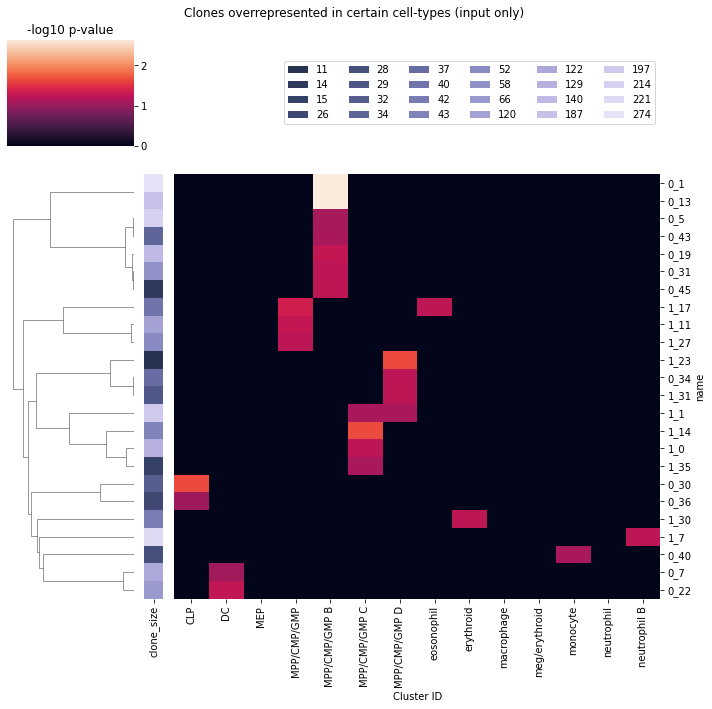

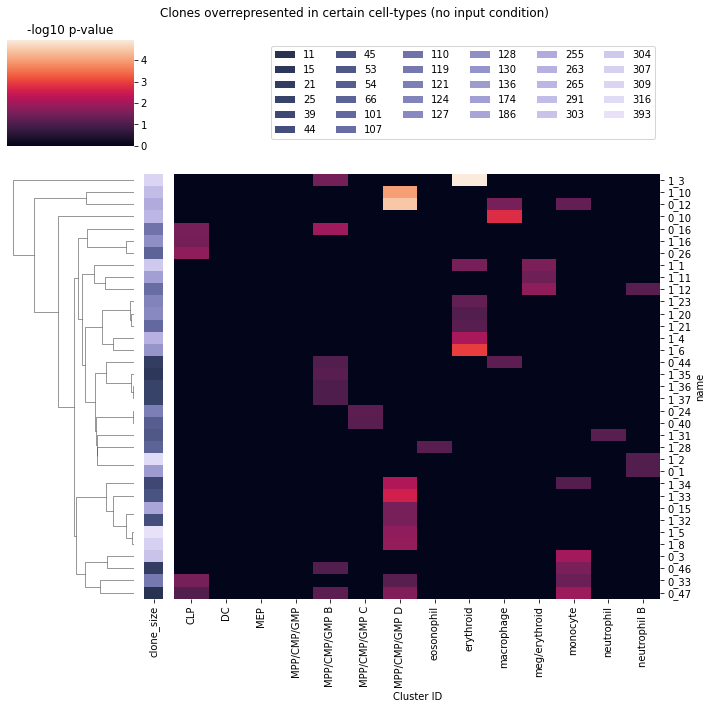

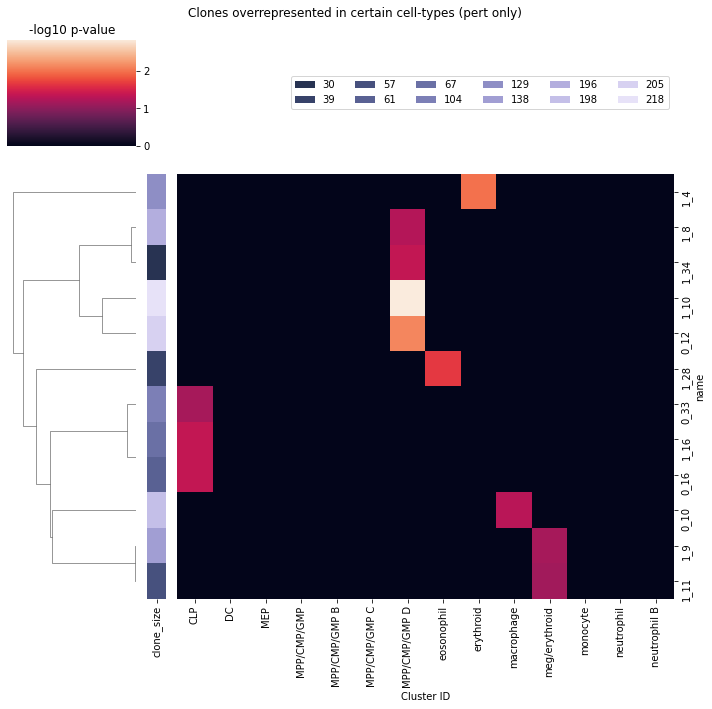

In [8]:
input_bh_enrichment_df = wrap_hyper(input_cells_meta, input_out_f, title="(input only)")
noIn_bh_enrichment_df = wrap_hyper(noInput_cells_meta, noInput_out_f, title="(no input condition)")
pert_bh_enrichment_df = wrap_hyper(pert_cells_meta, pert_out_f, title="(pert only)")


## Create merged df of significant shifted clones in culture and input

In [9]:
def merge_hypergeom(a_enrich_df, b_enrich_df, a_name, b_name, p_thresh=0.1, f_save=None):
    b_sig = b_enrich_df<0.1
    b_sig = b_sig.reset_index().melt(id_vars="name",value_name="sig", var_name=b_name)
    b_sig = b_sig[b_sig["sig"]].drop("sig",axis=1)
    a_sig = a_enrich_df<0.1
    a_sig = a_sig.reset_index().melt(id_vars="name",value_name="sig", var_name=a_name)
    a_sig = a_sig[a_sig["sig"]].drop("sig",axis=1)
    
    merged_df = pd.DataFrame(index=a_sig[a_name].unique(), columns=b_sig[b_name].unique()).astype(object)
    merged_df.loc[:,:] = ""
    merged_count_df = pd.DataFrame(index=a_sig[a_name].unique(), columns=b_sig[b_name].unique()).astype("Int64")
    merged_count_df = merged_count_df.fillna(0)

    for inp_ind, val in a_sig.iterrows():
        curr_clone = val["name"]
        curr_cult_df = b_sig.loc[b_sig["name"]==curr_clone]
        for noinp_ind, val2 in curr_cult_df.iterrows():
            merged_df.loc[val[a_name], val2[b_name]] = merged_df.loc[val[a_name], val2[b_name]] + curr_clone + ";"
            merged_count_df.loc[val[a_name], val2[b_name]] += 1

    merged_df = merged_df.apply(lambda ser: ser.apply(lambda x: x.strip(";")), axis=0)
    merged_df.index.name = a_name
    merged_df.columns.name = b_name
    merged_df
    f, ax = plt.subplots(figsize=(12,12), dpi=300)
    sns.heatmap(merged_count_df.astype(int), annot=merged_df, fmt="s")

    plt.ylabel(a_name)
    plt.xlabel(b_name)
    plt.title("Number of clones that are significant")
    
    if f_save is not None:
        plt.savefig(f_save+".png")
        merged_df.to_csv(f_save+".csv")
    return merged_df, merged_count_df

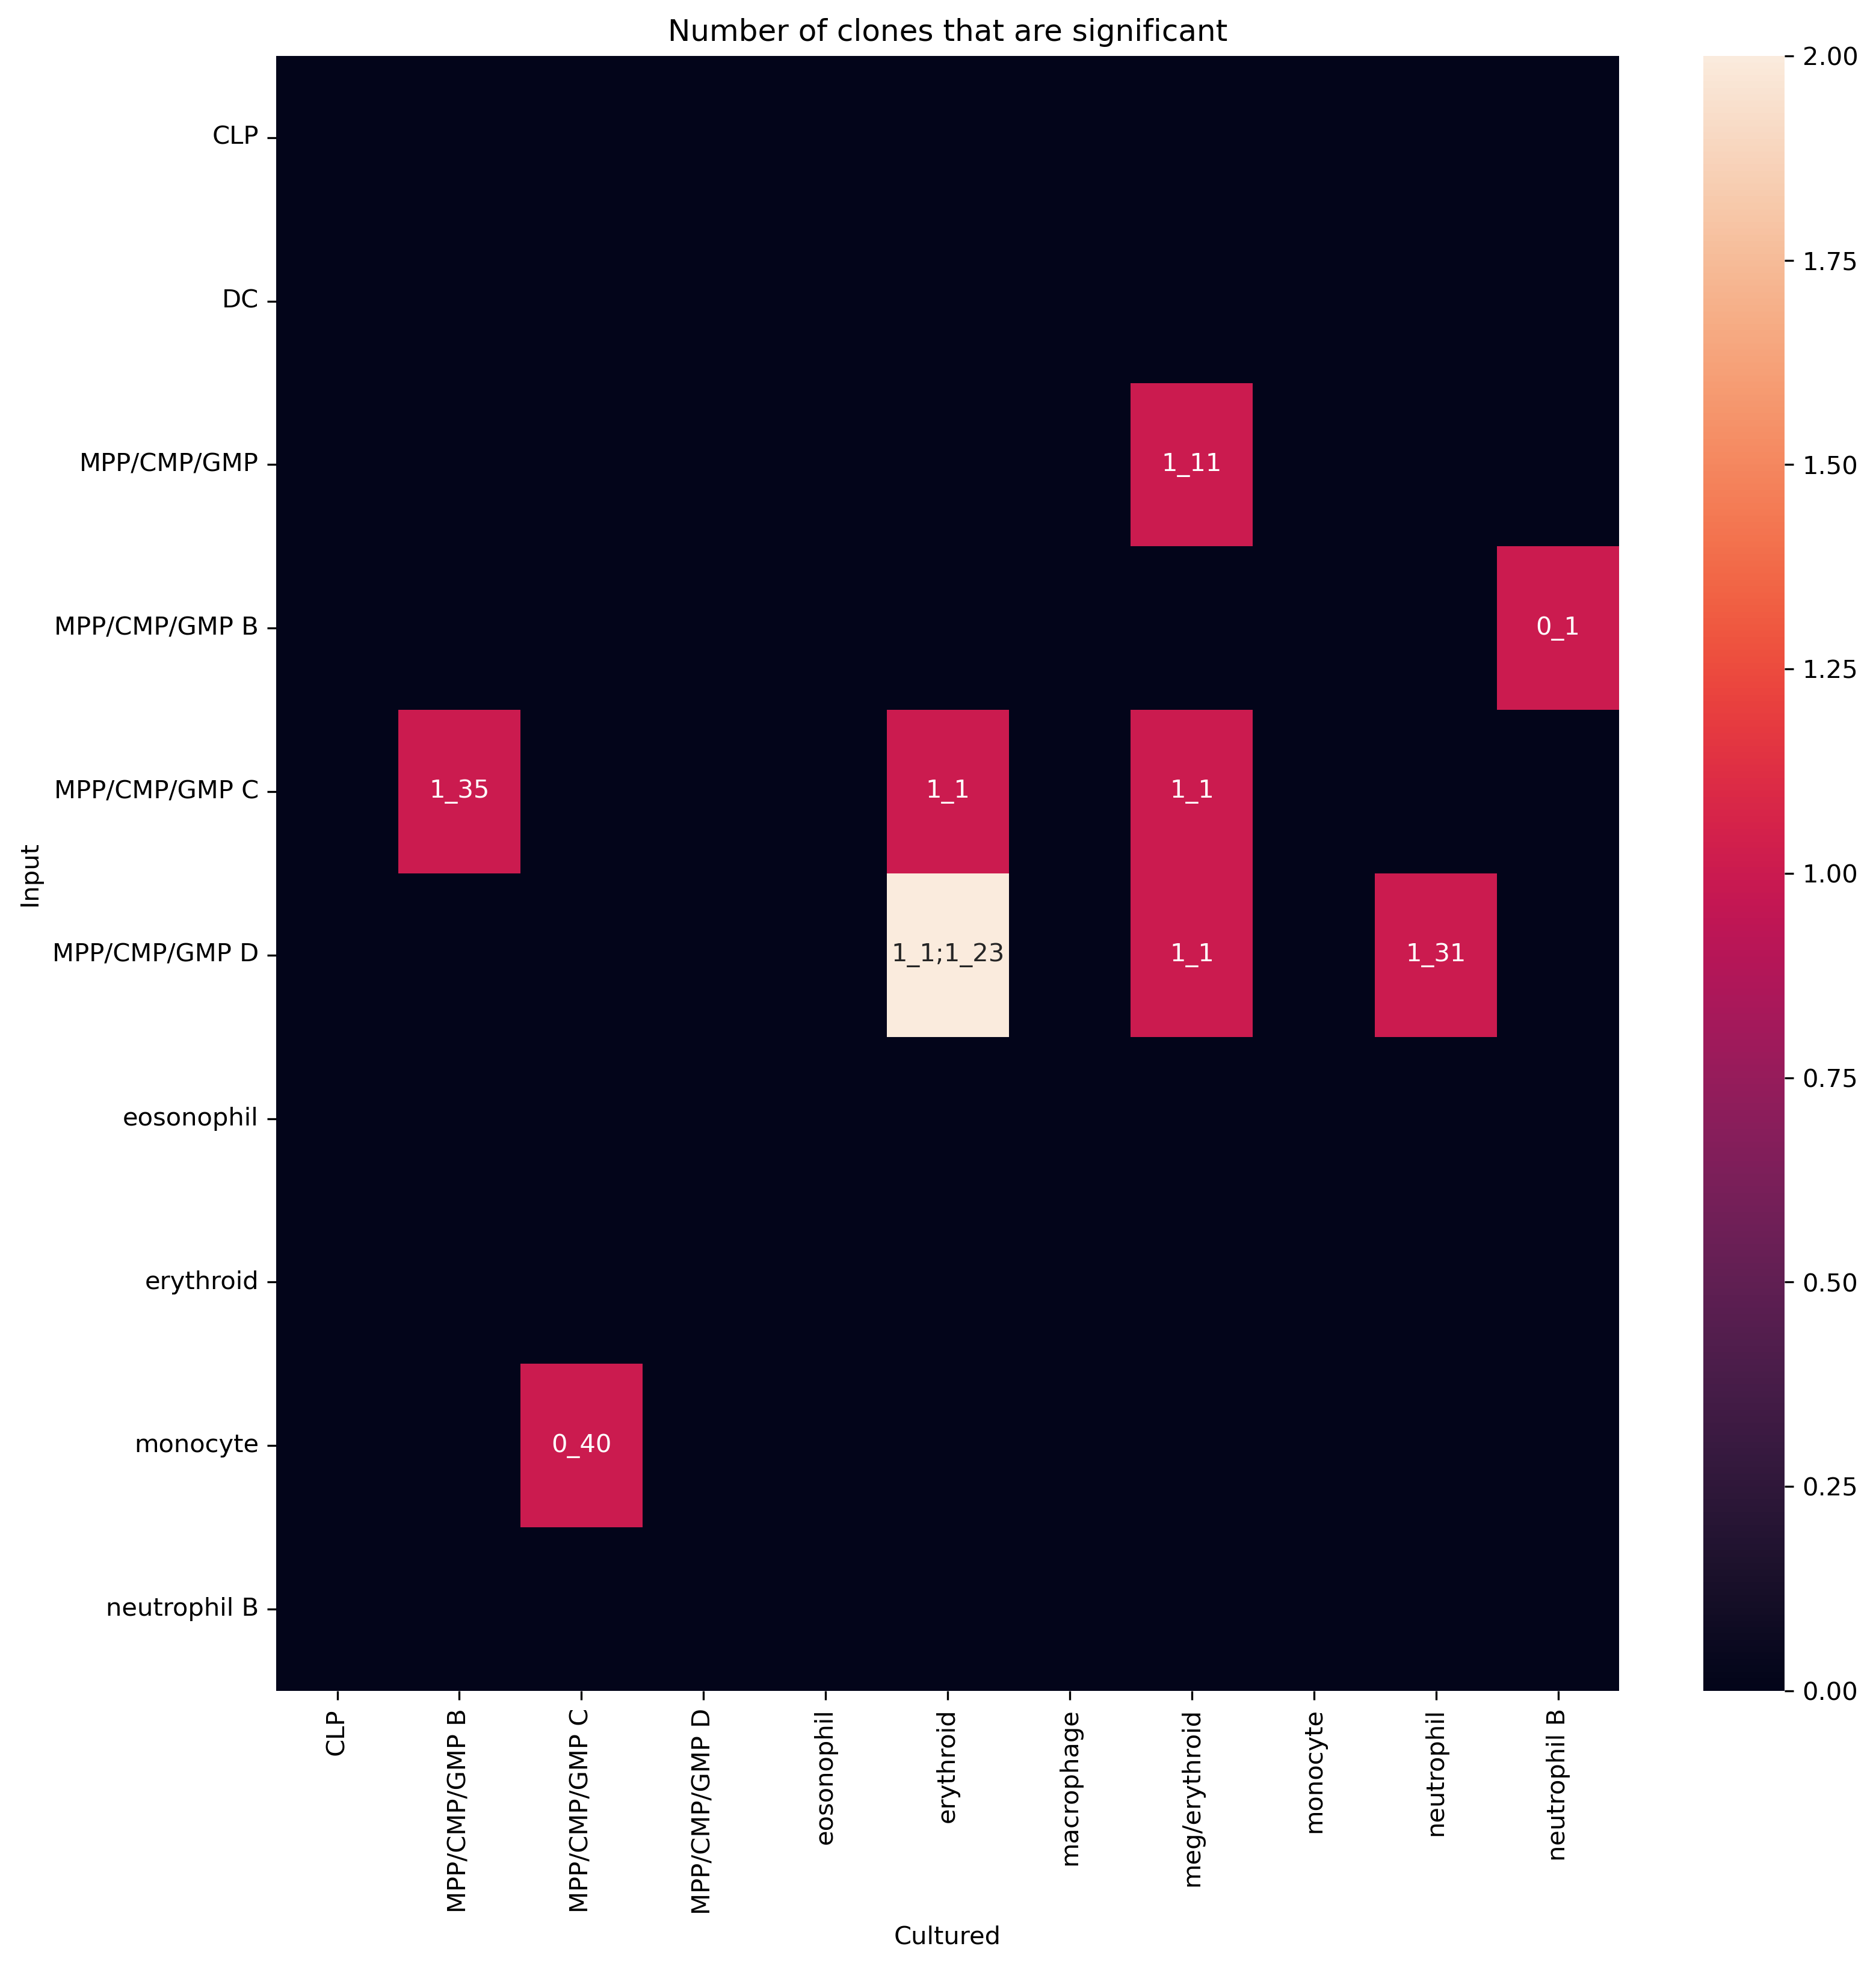

In [10]:
merged_df, merged_count_df = merge_hypergeom(input_bh_enrichment_df, noIn_bh_enrichment_df,
                                             "Input", "Cultured", p_thresh=0.1,
                                             f_save=join(outdir,f"cultured_{input_cond}_clone_lineages"))
                                            

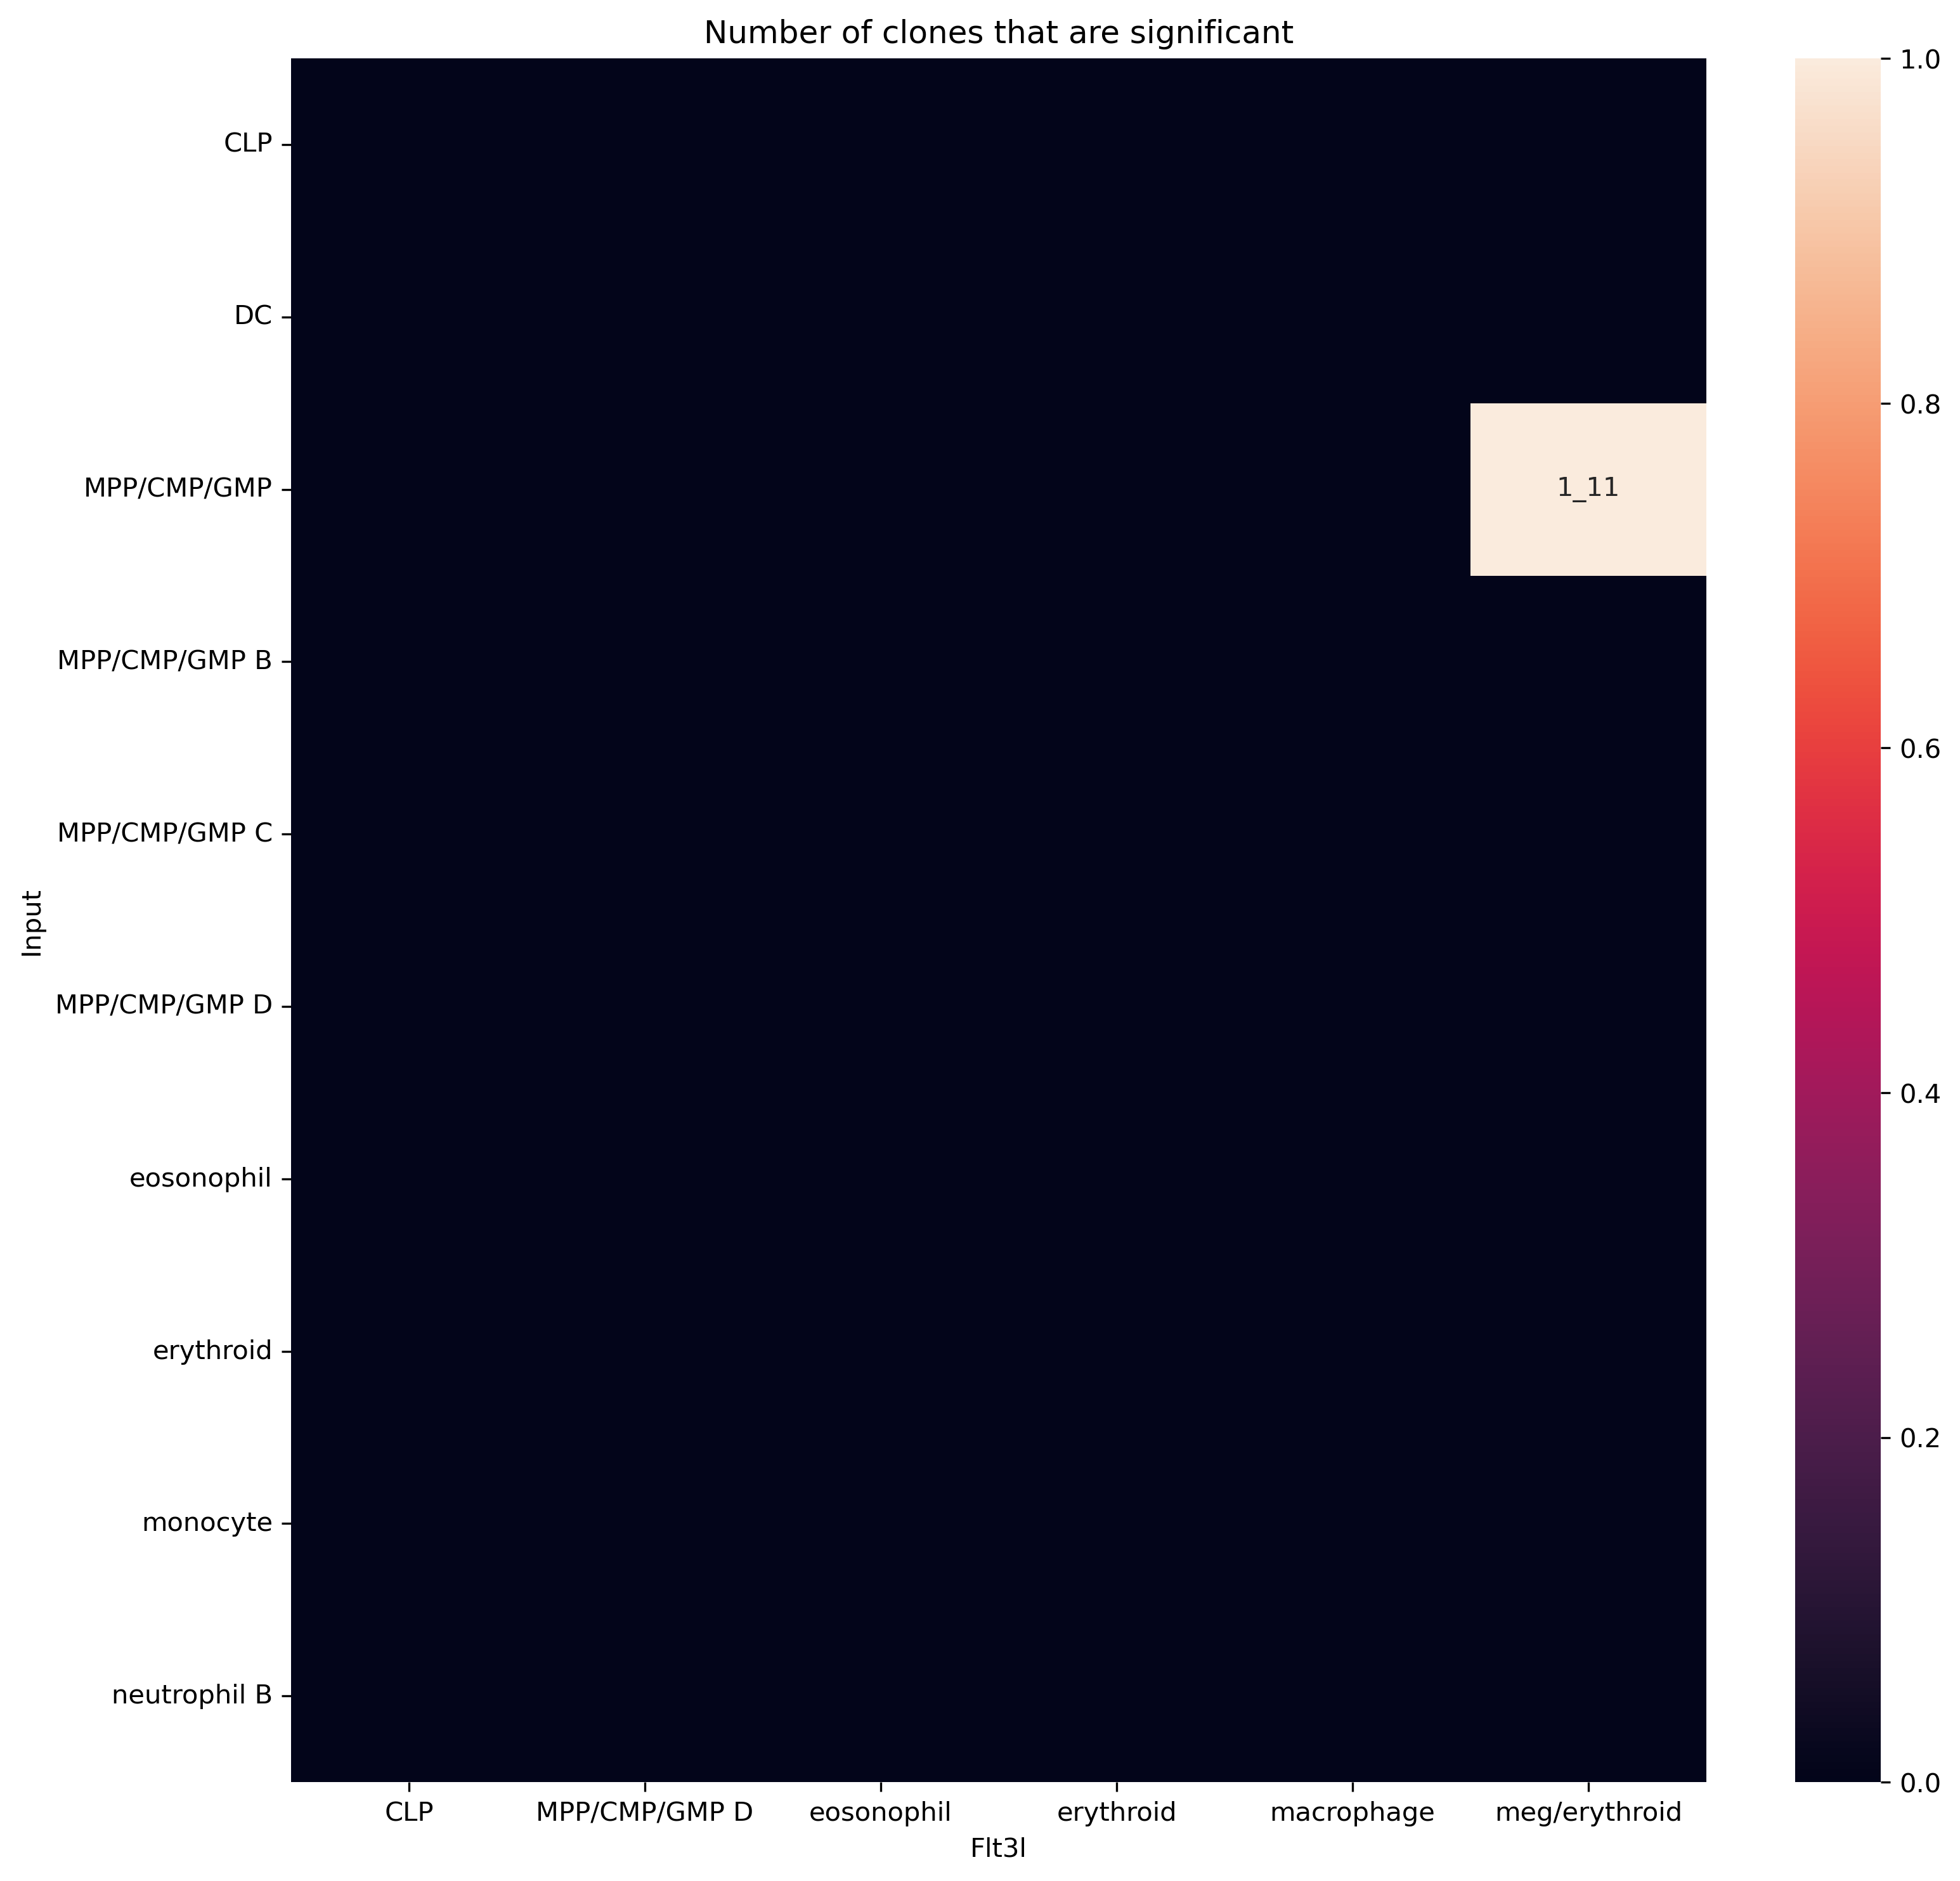

In [11]:
merged_df, merged_count_df = merge_hypergeom(input_bh_enrichment_df, pert_bh_enrichment_df, 
                                             "Input", "Flt3l", p_thresh=0.1, 
                                             f_save=join(outdir,f"{pert_cond}_{input_cond}_clone_lineages"))